In [1]:
RUNS_TO_STUDY = [
    'include_pruning_20201119',
#     'include_pruning_refactor_20201119'
]

RELATIVE_PATH_TO_SRC = '../src' # where this notebook is wrt to file containing the pareto simulation

In [77]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.spatial import ConvexHull
from IPython.display import set_matplotlib_formats

%matplotlib inline

set_matplotlib_formats('svg')


In [3]:
if RELATIVE_PATH_TO_SRC not in sys.path:
    sys.path.append(RELATIVE_PATH_TO_SRC)
import settings.settings as s

In [4]:
def read_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [5]:
def read_completed_jobs(run_id):
    job_dict = read_json(os.path.join(os.getcwd(), RELATIVE_PATH_TO_SRC, s.TRACKER_FOLDER, run_id + '.json'))
    return [job for job, status in job_dict.items() if status == 'completed']

In [135]:
def load_simulaton_results(run_id):
    
    # retrieve jobs from specificed id
    jobs = read_completed_jobs(run_id)
    print(f"{len(jobs)} completed jobs")
    
    # transform this into a list of paths to the model folder
    paths = [os.path.join(os.getcwd(), RELATIVE_PATH_TO_SRC, s.JOB_RUNS_FOLDER, run_id, job) for job in jobs]
    
    def read_info_from_folder(folder_path: str) -> dict:
        perf = read_json(os.path.join(folder_path, 'performance.json'))
        weights = read_json(os.path.join(folder_path, 'weights_info.json'))
        
        with open(os.path.join(folder_path, 'parameters.pickle'), 'rb') as f:
            try:
                param_dict = pickle.load(f)

                layers_weights = len(param_dict['grid_params']['layer_weights'])
                hidden_nodes = np.sum(param_dict['grid_params']['layer_weights'])
                pixels = param_dict['grid_params']['input_side_pixel']
            except EOFError:
                layers_weights = np.nan
                hidden_nodes = np.nan
                pixels = np.nan
        return {**perf, **weights, 'pixels': pixels, 'layers': layers_weights, 'hidden_nodes': hidden_nodes}

    data = []
    for path in tqdm(paths):
        # read baseline model info
        data.append({**read_info_from_folder(path), 'type': 'baseline'})
        
        # read pruned folders
        pruned_paths = glob.glob(os.path.join(path, 'pruned_*'))
        for ppath in pruned_paths:
            data.append({**read_info_from_folder(ppath), 'type': 'pruned'})

    return pd.DataFrame(data)

## Main

In [139]:
sim_res = pd.concat([load_simulaton_results(run) for run in RUNS_TO_STUDY])
sim_res.head()

288 completed jobs


,test_set_accuracy,trainable_weights,significative_weights,pixels,layers,hidden_nodes,type
0,0.5598,154.0,150.0,5,1,4,baseline
1,0.5616,154.0,136.0,5,1,4,pruned
2,0.2874,154.0,52.0,5,1,4,pruned
3,0.1172,154.0,25.0,5,1,4,pruned
4,0.4869,154.0,80.0,5,1,4,pruned


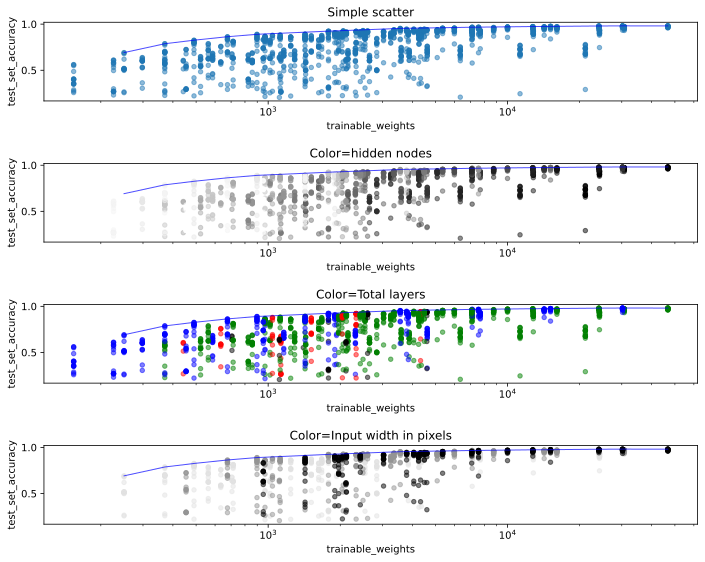

In [140]:
# column names
accuracy_col = 'test_set_accuracy'
xaxis_col = 'trainable_weights'
logx=True

df = sim_res.dropna()
df_filt = df[(df[accuracy_col] > 0.2) ][[xaxis_col, accuracy_col, 'hidden_nodes', 'layers', 'pixels']]
# & (df['trainable_weights'] < 15000)

fig, ax = plt.subplots( nrows=4)
# df_filt = pd.concat([df_filt,  pd.DataFrame({'trainable_weights': [0], 'best_accuracy': [0], 'hidden_nodes': 0, 'layers': 1, 'pixels': 10})])
hull_df = df_filt.groupby(xaxis_col).agg({accuracy_col: 'max'}).reset_index().sort_values(xaxis_col).values
hull = ConvexHull(hull_df)
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=logx, ax=ax[0], title='Simple scatter')
df_filt.plot.scatter(figsize=(10,8), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=logx, color=np.log(df_filt['hidden_nodes']), ax=ax[1], title='Color=hidden nodes')
df_filt.plot.scatter(figsize=(10,8), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=logx, color=df_filt['layers'].map({1: 'blue', 2: 'green', 3: 'red', 4: 'black'}), ax=ax[2],title='Color=Total layers')
df_filt.plot.scatter(figsize=(10,8), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=logx, color=df_filt['pixels'], ax=ax[3], title='Color=Input width in pixels')

for axx in ax:
    axx.plot(hull_df[hull.vertices[2:],0], hull_df[hull.vertices[2:],1], 'b-', lw=1, alpha=0.7)
plt.tight_layout()
plt.show()

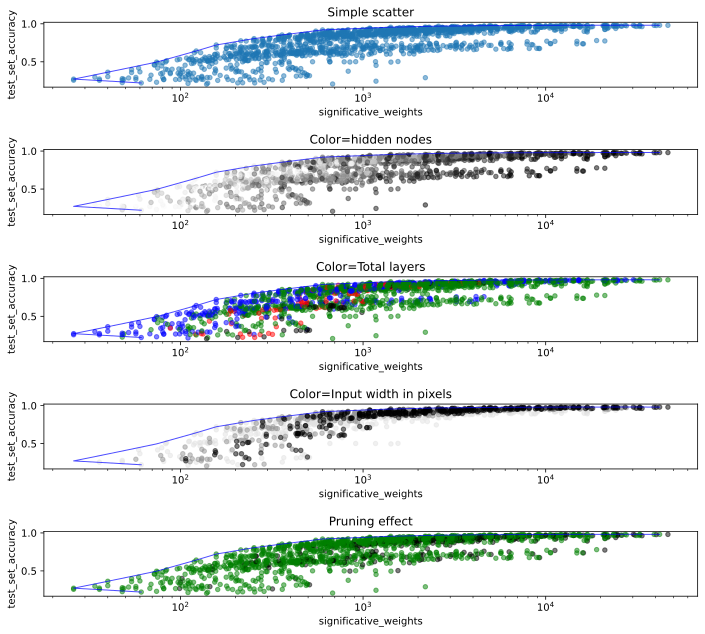

In [144]:
# column names
accuracy_col = 'test_set_accuracy'
xaxis_col = 'significative_weights'
log = True

df = sim_res.dropna()
df_filt = df[(df[accuracy_col] > 0.2)][[xaxis_col, accuracy_col, 'hidden_nodes', 'layers', 'pixels', 'type']]


fig, ax = plt.subplots( nrows=5)
# df_filt = pd.concat([df_filt,  pd.DataFrame({'trainable_weights': [0], 'best_accuracy': [0], 'hidden_nodes': 0, 'layers': 1, 'pixels': 10})])
hull_df = df_filt.groupby(xaxis_col).agg({accuracy_col: 'max'}).reset_index().sort_values(xaxis_col).values
hull = ConvexHull(hull_df)
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=log, ax=ax[0], title='Simple scatter')
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=log, color=np.log(df_filt['hidden_nodes']), ax=ax[1], title='Color=hidden nodes')
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=log, color=df_filt['layers'].map({1: 'blue', 2: 'green', 3: 'red', 4: 'black'}), ax=ax[2],title='Color=Total layers')
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=log, color=df_filt['pixels'], ax=ax[3], title='Color=Input width in pixels')
df_filt.plot.scatter(figsize=(10,9), x=xaxis_col, y=accuracy_col, alpha=0.5, logx=log, color=df_filt['type'].map({'baseline': 'black', 'pruned': 'green'}), ax=ax[4], title='Pruning effect')
for axx in ax:
    axx.plot(hull_df[hull.vertices[2:],0], hull_df[hull.vertices[2:],1], 'b-', lw=1, alpha=0.7)
plt.tight_layout()
plt.show()

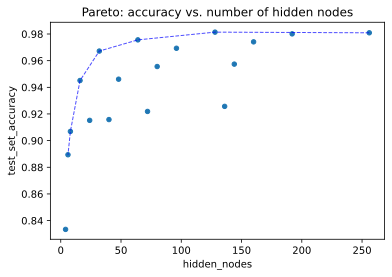

In [87]:
best_acc_per_nodes = df_filt.groupby('hidden_nodes')['test_set_accuracy'].max()
bf = best_acc_per_nodes.reset_index()
hull = ConvexHull(bf)
bf.plot.scatter(x='hidden_nodes', y='test_set_accuracy')
plt.plot(bf.values[hull.vertices[1:],0], bf.values[hull.vertices[1:],1], 'b--', lw=1, alpha=0.7)
plt.title('Pareto: accuracy vs. number of hidden nodes')
plt.show()

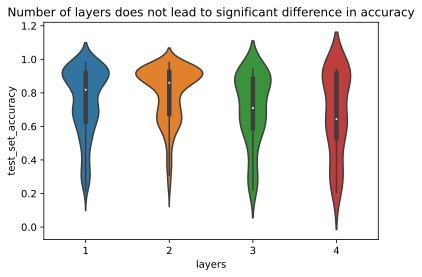

In [88]:
sns.violinplot(data=df_filt, x='layers', y='test_set_accuracy')
plt.title("Number of layers does not lead to significant difference in accuracy")
plt.show()

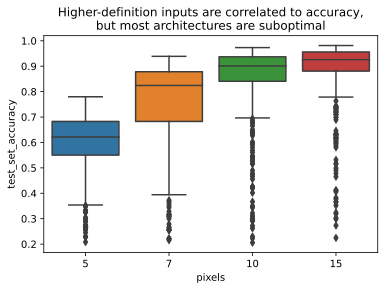

In [93]:
sns.boxplot(data=df_filt, x='pixels', y='test_set_accuracy')
plt.title("Higher-definition inputs are correlated to accuracy,\nbut most architectures are suboptimal")
plt.show()

In [134]:
from itertools import permutations
all_perms = []
total_len = 6
ints = list(range(2,total_len+1))
for r in ints:
    all_perms.extend([list(x) for x in permutations(ints, r=r)])
print(len(all_perms))

320
